In [58]:
data_root = "../../data/"

#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ML stuff
import numpy as np
from numpy.fft import *
import torch
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import pandas as pd
import lightgbm as lgb
# from optuna.integration import lightgbm as lgb
import optuna


# DL stuff
from torch.autograd import Variable
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# plotting
import matplotlib.pyplot as plt
import seaborn as sns



# basic stuff
import datetime
import requests
import io
import os
from collections import Counter
from tqdm import tqdm

# relative imports
# from GBT_preprocess import get_Xy,\
#      get_train_test, reindex, get_stock,\
#          sliding_windows_mutli_features,\
#              get_features, get_train_df
# from hfuncs import check_mkdir

import warnings
warnings.filterwarnings("ignore")

In [78]:
# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

############## REINDEX FUNCTION AND PREPARE_STOCK FUNCTION ARE PRETTY MUCH SAME, HOWEVER, I PREFER THE PRIOR ##################
# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq
#############################################################################################################################

# create features volatility, volume, adj close
# df must be passed through date_index_nasdaq or prepare_stock
def get_features(df, features):
    #rename Adj Close
    
    df.rename(columns={"Adj Close":"Adj_Close"}, inplace=True) 
    df["log_Volatility"] = np.log(df.High - df.Low + 1)
    df["log_Volume"] = np.log(df.Volume + 1) 
    df["log_Adj_Close"] = np.log(df["Adj_Close"] + 1)
    # df["day_of_week"] = np.array(list(map(lambda date: date.weekday(), df.index)))

    if 'Adj_Close' not in features:
        df.drop(columns=["Adj_Close"], inplace=True)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()

    df.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq = nasdaq[features]

    # nasdaq.dropna(inplace = True)
    return df

# this will return feature engineered stock dataframe
def get_stock(nasdaq, features, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock, features)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

####### In the 2 functions below, we are adding weekday however ###########
####### prob we could have done this in like get_stock or something #######
# the main difference between the two is , the prior is just adding weekday at the end,
# whereas the latter function is adding it to every stock
def get_train_df(nasdaq, using, features):
    df_features_arr = reindex(get_stock(nasdaq, using[0])).to_numpy().T
    for name in using[1:]:
        adding = reindex(get_stock(nasdaq, name)).to_numpy().T
        df_features_arr = np.concatenate([df_features_arr, adding])
    df_features_arr = df_features_arr.T

    ## df_features = pd.DataFrame(data=df_features_arr, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))
    
    # making columns
    # features must not include weekday here
    if "weekday" in features:
        features.remove("weekday")
    col_one = []
    for element in using:
        for i in range(len(features)):
            col_one.append(element)
    col_two = list(features)*len(using)
    # print(len(col_one), len(col_two))

    # scaling 
    scaler = MinMaxScaler((-1, 1))
    scaled = scaler.fit_transform(df_features_arr)
    df_features = pd.DataFrame(data=scaled, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))

    df_features.index = pd.date_range("2012-05-18", "2021-09-10")

    day_of_week = np.array(list(map(lambda date: date.weekday(), df_features.index)))
    day_of_week = day_of_week.reshape(-1, 1)
    day_of_week = pd.Series(data=scaler.fit_transform(day_of_week).reshape(-1,), index = df_features.index)
    df_features["weekday"] = day_of_week
    if "weekday" not in features:
        features.append("weekday")

    return df_features, features

# for feeding into network
def get_train_arr(nasdaq, using, features):
    df_features_arr = []
    for name in using:
        arr = reindex(get_stock(nasdaq, name)).to_numpy()
        # scaling for each column, for each stock_df in nasdaq
        scaler = MinMaxScaler(feature_range=(-1, 1))
        arr_scaled = scaler.fit_transform(arr)    

        # adding day of week
        day_of_week = np.array(list(map(lambda date: date.weekday(), pd.date_range("2012-05-18", "2021-09-10"))))
        day_of_week = day_of_week.reshape(-1, 1)
        day_of_week = scaler.fit_transform(day_of_week)
      
        arr_scaled = np.concatenate([arr_scaled, day_of_week], axis=1)

        df_features_arr.append(arr_scaled)


    df_features_arr = np.array(df_features_arr)
    if "weekday" not in features:
        features.append("weekday")
    df_features_arr = df_features_arr.reshape(-1, len(features), 7)

    return df_features_arr, features

def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def get_Xy(df, window_size):
    log_adj_close_cols_ids = []
    volatility_cols_ids = []
    volume_cols_ids = []
    weekday_col_id = []
    count = 0
    for col in df.columns:
        # print(col)
        if col[1] == "Adj_Close":
            df.drop(col, axis=1, inplace=True)
            count -= 1
        if col[1] == "log_Adj_Close":
            log_adj_close_cols_ids.append(count)
        if col[1] == "log_Volume":
            volume_cols_ids.append(count)
        if col[1] == "log_Volatility":
            volatility_cols_ids.append(count)
        if col[0] == "weekday":
            weekday_col_id.append(count)
        count += 1
    df = df.to_numpy()
    x, y = sliding_windows_mutli_features(df, window_size, log_adj_close_cols_ids)

    # x.shape, y.shape
    return x, y

def get_train_test(x, y, train_ratio):
    train_size = int(len(y)*train_ratio)
    test_size = len(y) - train_size

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    return trainX, trainY, testX, testY

In [114]:
def load_for_lgb(stock_name):
    nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
    train_ratio = 0.90
    valid_ratio = 0.15
    features = ["log_Volatility", "log_Volume", "log_Adj_Close"]
    # using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']

    aapl = get_stock(nasdaq, features, stock_name=stock_name)
    train_size = int(len(aapl)*train_ratio)
    y_ = aapl[["log_Adj_Close"]]
    y = y_.shift(-1) - y_ 
    y = y.iloc[:-1]
    X = aapl.iloc[:-1]
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    valid_size = int(len(aapl)*valid_ratio)
    X_train_v, X_valid = X[:-valid_size], X[-valid_size:]
    y_train_v, y_valid = y[:-valid_size], y[-valid_size:]

    return X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid

def load_for_lgb_scale(stock_name):
    scaler = StandardScaler()
    to_scale = load_for_lgb(stock_name)
    return [scaler.fit_transform(element) for element in to_scale]

def to_three(y):
    if -0.1<y<0.1:
        y = int(1)
    elif y>=0.1:
        y = int(2)
    else:
        y = int(0)
    return y
    
def to_two(y):
    if y<0:
        y = 0
    else:
        y = 1

def to_classes(arr, to_class):
    return np.array(list(map(lambda y: to_class(y), arr)))

# def scale(arr):
#     scaler = StandardScaler()
#     arr = arr.T
#     return scaler.fit_transform(arr).T

# def scale_all(arrs):
#     return list(map(lambda arr: scale(arr), arrs))


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
[1]	valid_0's multi_logloss: 0.953571
[2]	valid_0's multi_logloss: 0.955835
[3]	valid_0's multi_logloss: 0.95859
[4]	valid_0's multi_logloss: 0.96307
[5]	valid_0's multi_logloss: 0.967988
[6]	valid_0's multi_logloss: 0.969946
[7]	valid_0's multi_logloss: 0.975993
[8]	valid_0's multi_logloss: 0.97919
[9]	valid_0's multi_logloss: 0.983939
[10]	valid_0's multi_logloss: 0.988691
[11]	valid_0's multi_logloss: 0.991961
[12]	valid_0's multi_logloss: 0.997422
[13]	valid_0's multi_logloss: 1.00112
[14]	valid_0's multi_logloss: 1.00228
[15]	valid_0's multi_logloss: 1.00568
[16]	valid_0's multi_logloss: 1.00952
[17]	valid_0's multi_logloss: 1.01115
[18]	valid_0's multi_logloss: 1.01254
[19]	valid_0's multi_logloss: 1.01691
[20]	valid_0's multi_logloss: 1.02075
[21]	valid_0's multi_logloss: 1.02219
[22]	valid_0's multi_logloss: 1.02464
[23]	valid_0's multi_logloss: 1.02621
[24]	valid_0's multi_logloss

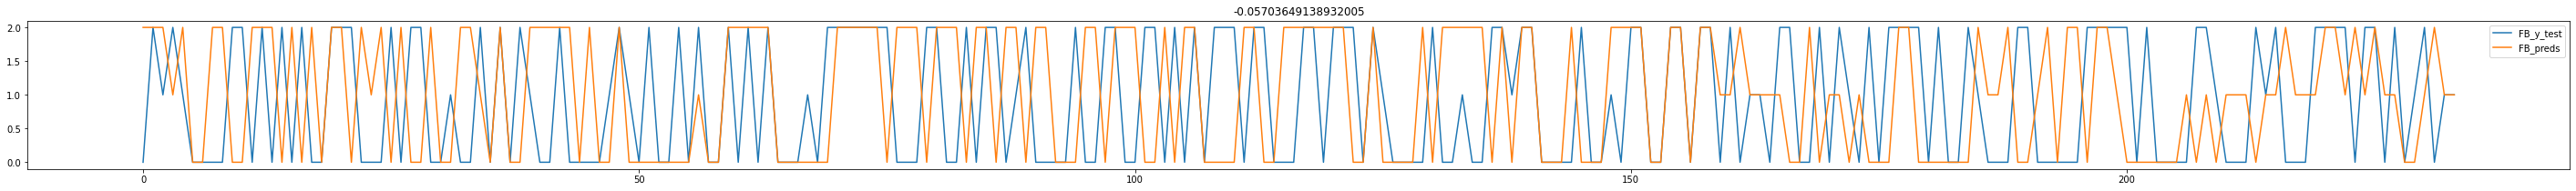

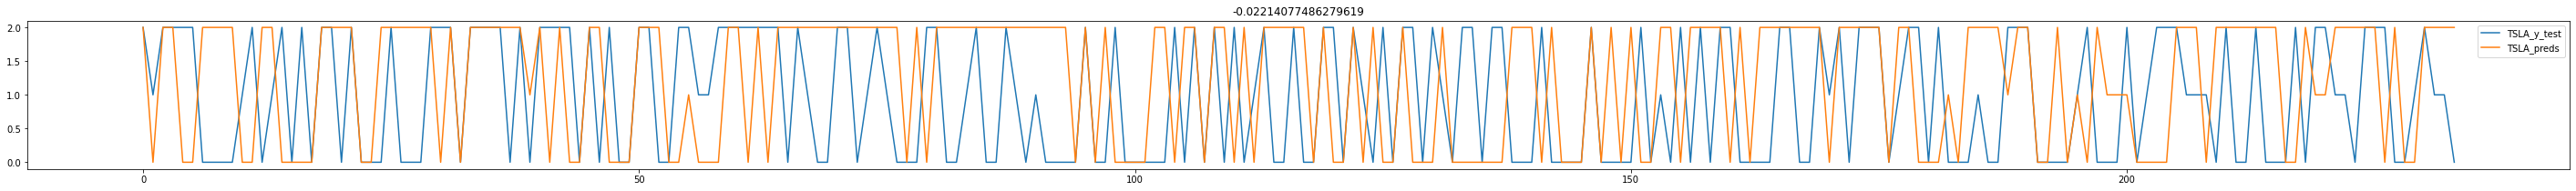

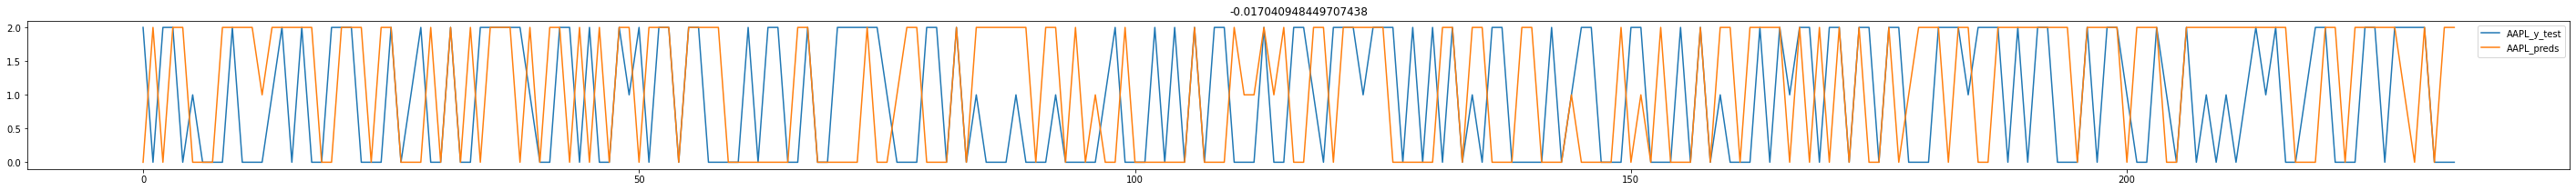

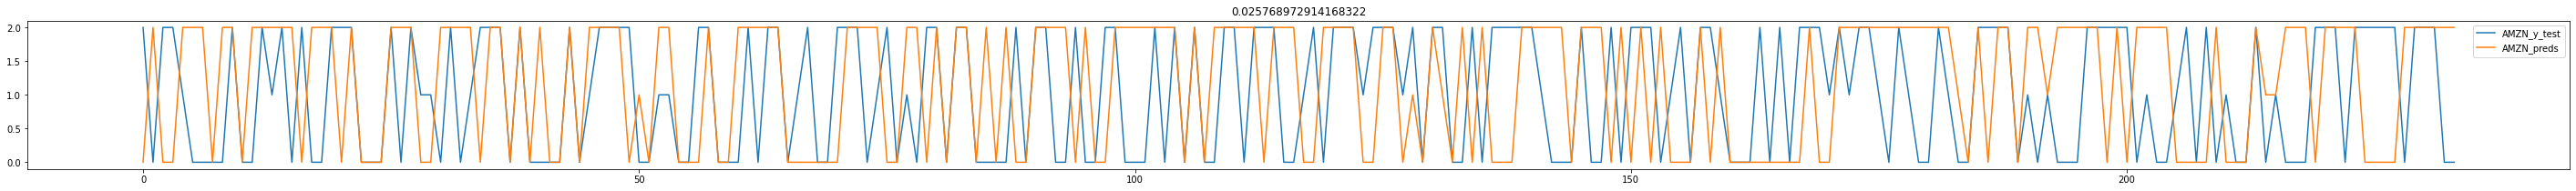

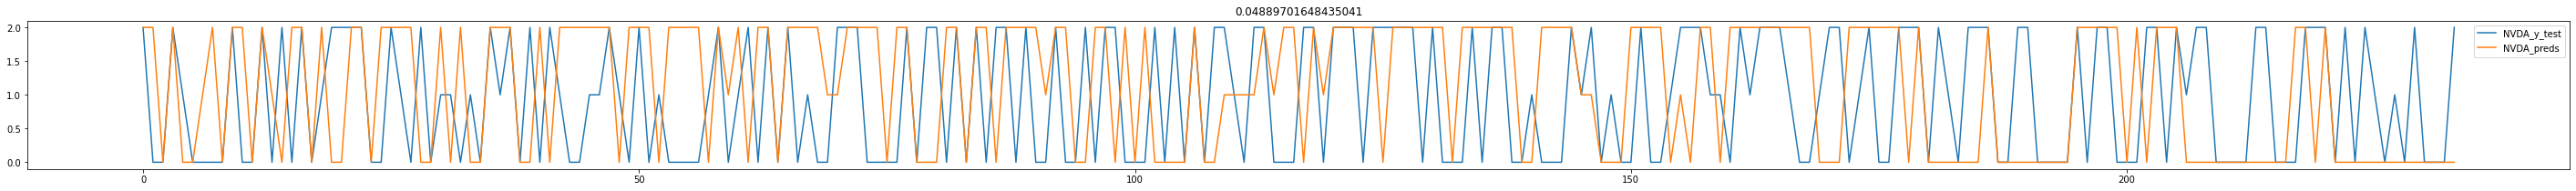

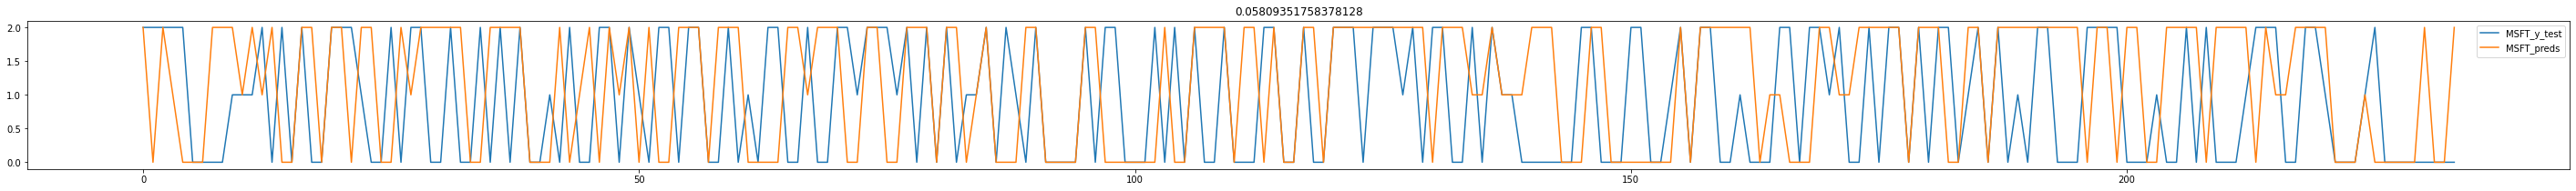

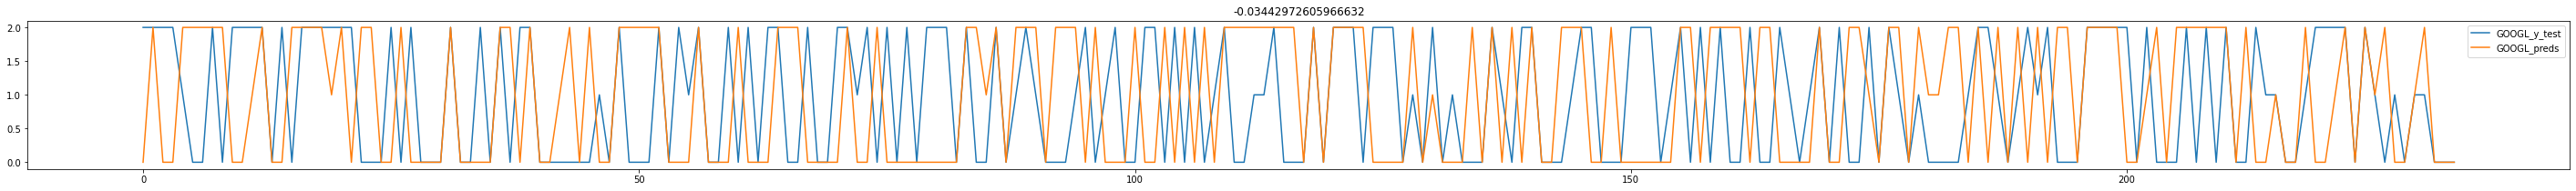

In [122]:
for stock_name in using:
    X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb_scale(stock_name)
    y_train, y_test, y_train_v, y_valid = list(map(lambda arr:to_classes(arr, to_three),[y_train, y_test, y_train_v, y_valid]))

    features = ["log_Volatility", "log_Volume", "log_Adj_Close"]
    nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
    aapl = get_stock(nasdaq, features)
    train_idx, test_idx = aapl[:X_train.shape[0]-X_train_v.shape[0]-X_valid.shape[0]],nasdaq[X_train.shape[0]:] 


    # y_train, y_test, y_valid = list(map(lambda arr:to_classes(arr.to_numpy(), to_three), [y_train, y_test, y_valid]))
    lgb_train = lgb.Dataset(X_train_v, label=y_train_v)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid)
    # print("y_test", y_test)
    # print("X_test", X_test)

    params = {
        'objective':'multiclass',
        'metric':'multi_logloss',
        'num_class':3,
        'verbosity':-1,
        'boosting_type':'gbdt',
        'verbose':-1
    }    
    model = lgb.train(params, lgb_train, valid_sets=lgb_valid)

    preds = model.predict(X_test)

    # model = lgb.LGBMClassifier(**params)
    # model.fit(X_train, y_train)
    # preds = model.predict(X_test)

    plt.figure(figsize=(50,3))
    # plt.plot(test_idx, preds)
    # plt.plot(preds)
    # plt.plot(test_idx, y_test)
    plt.plot(y_test)
    # print(np.corrcoef(preds, y_test))
    preds_ = np.array([np.argmax(row) for row in preds])
    plt.plot(preds_)
    plt.legend([f"{stock_name}_y_test", f"{stock_name}_preds"])
    plt.title(f"{np.corrcoef(preds_, y_test)[0][1]}")
    plt.savefig(f"threes_{stock_name}.png", facecolor="white", transparent=False)
    plt.show

    print(stock_name, np.corrcoef(preds_, y_test)[0][1])

In [115]:
X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb_scale("AMZN")
y_train, y_test, y_train_v, y_valid = list(map(lambda arr:to_classes(arr, to_three),[y_train, y_test, y_train_v, y_valid]))

features = ["log_Volatility", "log_Volume", "log_Adj_Close"]
nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
aapl = get_stock(nasdaq, features)
train_idx, test_idx = aapl[:X_train.shape[0]-X_train_v.shape[0]-X_valid.shape[0]],nasdaq[X_train.shape[0]:] 


# y_train, y_test, y_valid = list(map(lambda arr:to_classes(arr.to_numpy(), to_three), [y_train, y_test, y_valid]))
lgb_train = lgb.Dataset(X_train_v, label=y_train_v)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)
# print("y_test", y_test)
# print("X_test", X_test)

[1]	valid_0's multi_logloss: 0.949607
[2]	valid_0's multi_logloss: 0.950897
[3]	valid_0's multi_logloss: 0.952483
[4]	valid_0's multi_logloss: 0.95493
[5]	valid_0's multi_logloss: 0.956118
[6]	valid_0's multi_logloss: 0.959434
[7]	valid_0's multi_logloss: 0.962422
[8]	valid_0's multi_logloss: 0.963466
[9]	valid_0's multi_logloss: 0.964395
[10]	valid_0's multi_logloss: 0.964648
[11]	valid_0's multi_logloss: 0.966831
[12]	valid_0's multi_logloss: 0.967636
[13]	valid_0's multi_logloss: 0.968154
[14]	valid_0's multi_logloss: 0.967139
[15]	valid_0's multi_logloss: 0.968016
[16]	valid_0's multi_logloss: 0.970106
[17]	valid_0's multi_logloss: 0.96981
[18]	valid_0's multi_logloss: 0.971971
[19]	valid_0's multi_logloss: 0.973638
[20]	valid_0's multi_logloss: 0.97705
[21]	valid_0's multi_logloss: 0.980004
[22]	valid_0's multi_logloss: 0.980158
[23]	valid_0's multi_logloss: 0.98333
[24]	valid_0's multi_logloss: 0.983602
[25]	valid_0's multi_logloss: 0.986003
[26]	valid_0's multi_logloss: 0.987413

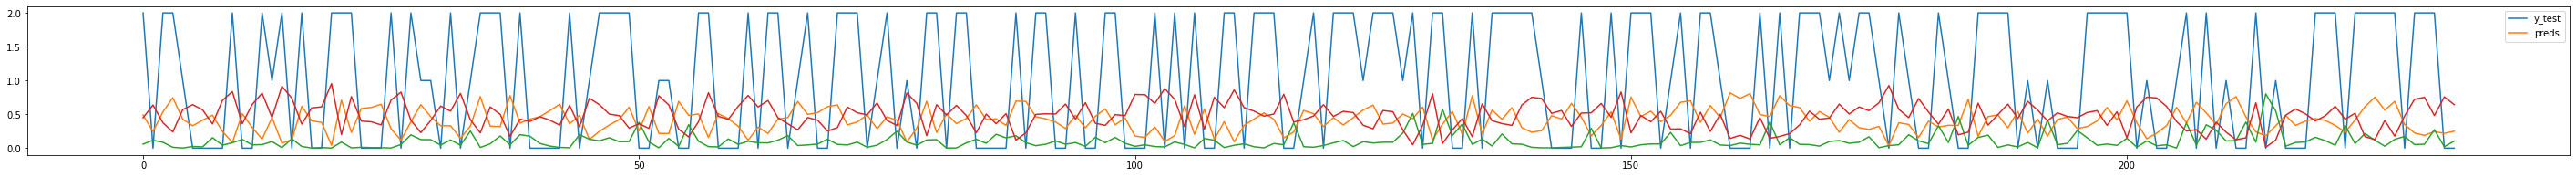

In [117]:

params = {
    'objective':'multiclass',
    'metric':'multi_logloss',
    'num_class':3,
    'verbosity':-1,
    'boosting_type':'gbdt'
}    
model = lgb.train(params, lgb_train, valid_sets=lgb_valid)

preds = model.predict(X_test)

# model = lgb.LGBMClassifier(**params)
# model.fit(X_train, y_train)
# preds = model.predict(X_test)

plt.figure(figsize=(50,3))
# plt.plot(test_idx, preds)
# plt.plot(preds)
# plt.plot(test_idx, y_test)
plt.plot(y_test)
# print(np.corrcoef(preds, y_test))
preds_ = np.array([np.argmax(row) for row in preds])
plt.plot(preds)
plt.legend(["y_test", "preds"])
# plt.savefig("threes2.png")

print(np.corrcoef(preds_, y_test)[0][1])

{'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 200, 'early_stopping_round': 50}


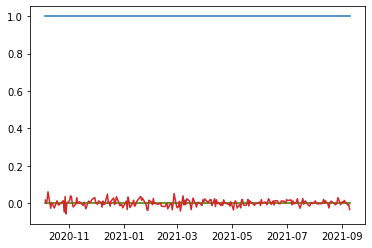

In [76]:

X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb()
lgb_train = lgb.Dataset(X_train_v, label=y_train_v)
lgb_valid = lgb.Dataset(X_valid, label=y_valid)

params={
    'objective':'multiclass',
    'metric':'multi_logloss',
    'num_class':3,
    'verbosity':-1,
    'boosting_type':'gbdt'
}    

best_params, history = {}, []

model = lgb.train(params,
                  lgb_train,
                  num_boost_round=200,
                  valid_sets=[lgb_train, lgb_valid],
                  early_stopping_rounds=50,
                #   best_params=best_params,
                  verbose_eval=False,
                #   history=history,
)

print(model.params)

plt.plot(y_test.index, model.predict(X_test))
plt.plot(y_test.index, y_test.values)

In [113]:

def objective(trial):
    X_train, y_train, X_test, y_test, X_train_v, y_train_v, X_valid, y_valid = load_for_lgb()

    param = {
        'objective': 'regression',
        'metric': 'rmse',
        # 'num_class':3,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    lgb_train = lgb.Dataset(X_train_v, label=y_train_v)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid)
    model = lgb.train(param, lgb_train, valid_sets=lgb_valid)

    y_pred = model.predict(X_test)

#   Must change error function to something of multiclass log loss
    error = np.corrcoef(y_test, y_pred)[0][1]

    return error

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)#42 secs for 1 trial

print("finished_trials", len(study.trials))
print("best trial", study.best_trial.params)

best_params = study.best_trial.params

[I 2022-01-16 10:26:30,372] A new study created in memory with name: no-name-f6fbb4b3-c88d-47b2-ba59-c0967d33c647
[W 2022-01-16 10:26:30,711] Trial 0 failed because of the following error: ValueError('all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 234')
Traceback (most recent call last):
  File "/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/c5/nv2shz796rnc77pvdpyqmhwm0000gn/T/ipykernel_45493/2931390764.py", line 24, in objective
    error = np.corrcoef(y_test, y_pred)[0][1]
  File "<__array_function__ internals>", line 5, in corrcoef
  File "/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/numpy/lib/function_base.py", line 2551, in corrcoef
    c = cov(x, y, rowvar)
  File "<__array_function__ internals>", line 5, in cov
  F

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1992, number of used features: 3
[LightGBM] [Info] Start training from score 0.000683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's rmse: 0.0198132
[LightGBM] [Warning] No further

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 234